# Iterative Hessian Sketching for Regression
Code to reproduce results from https://arxiv.org/abs/1411.0347

In [1]:
import numpy as np
import scipy as sp
from sklearn.datasets import make_regression
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.linalg import norm

In [2]:
def gaussian_sketch(nrows, ncols):
    '''Generate a Gausian sketching matrix of size
    (nrows, ncols)'''
    return (1/np.sqrt(nrows))*np.random.randn(nrows, ncols)

In [3]:
def generate_data(nsamples, nfeatures, variance=1):
    '''Generates a data matrix of size (nsamples, nfeatures)
    which defines a linear relationship on the variables.'''
    X, y, coef = make_regression(n_samples=nsamples, n_features=nfeatures,\
                        n_informative=nfeatures,noise=variance,coef=True)
    #X[:,0] = np.ones(shape=(nsamples)) # add bias terms
    return X, y, coef

In [4]:
X,y, coef = generate_data(1000,2)
print(coef)
print(X.shape)

[ 53.68660231  19.62507652]
(1000, 2)


In [5]:
def iterative_hessian(data, targets, sketch_size, num_iters):
    '''
    Input:
    data - n x d matrix
    targets - n x 1 target variables
    num_iters - how many iterations to perform.  
    Need log(1/eps) -- > num_iters for eps accuracy where
    eps is relative error in the semi-norm ||u-v||_A = 
    1/sqrt(n)*||A(u-v)||_2.
    
    
    Add functionality for lower bound on sketch size
    '''
    A = data
    y = targets
    n,d = A.shape
    x0 = np.zeros(shape=(d,1))
    m = int(sketch_size) # sketching dimension
    
    ATy = A.T.dot(y)[:,None]
    covariance_mat = A.T.dot(A)
   
    for n_iter in range(int(num_iters)):
        S = gaussian_sketch(m, n)
        S_A = S.dot(A)
        B = S_A.T.dot(S_A)
        z = ATy - covariance_mat.dot(x0) + np.dot(S_A.T, (np.dot(S_A,x0)))
        sol = sp.linalg.lstsq(B,z)
        x_new = sol[0] 
        
        
        ### KEEP BELOW AS THIS WILL BE USED FOR LASSO OR
        ### PENALISED REGRESSION.
        
        #x0 = np.zeros((X.shape[0],1))
        #xt = np.zeros((2,1))
        #x_new = np.zeros((2,1))
        #for it in range(20):
        #    result = minimize(f2min, x0=x_new,args=(X,y,x_new),
        #                     method='L-BFGS-B', jac=False )
        #    print(result)
        #    x_new = result.x
        
        x_new = sp.linalg.solve(B,z)
        #print("ITERATION {}: ||x_t - x_t+1|| = {}".\
                  #format(n_iter, np.linalg.norm(x0-x_new)))
        x0 = x_new
    return np.ravel(x0)

In [6]:
x_hat = iterative_hessian(X,y, X.shape[0]//2, 10)

/Users/cdickens/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [7]:
x_hat

array([ 53.73342548,  19.62552371])

In [8]:
x_true = sp.linalg.lstsq(X,y)
x_true[0]
print(x_true[0][:,None].shape)


(2, 1)


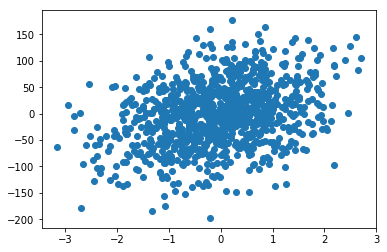

In [9]:
fig, ax = plt.subplots()
ax.scatter(X[:,1], y)
#ax.plot(X[:,1], np.sort(X@coef))
#ax.plot(X[:,1],X@x_hat)

### Checking the optimisation step
We need to use $x_{t+1} \leftarrow \text{argmin}_{x \in C} \|SA(x-x_t)\|_2^2 - (y - Ax_t)^TAx$.  To do this we will invoke the scipy minimizer but we this only minimises with one dimensional inputs so we need a local function.  

In [10]:
def lstsq(start_x, sketch, data, target):
    S = sketch #
    A = data
    y = target
    x0 = start_x
    return norm(S@A@x0-S@y)**2

In [11]:
res = minimize(lstsq, x0=np.zeros((2,1)),args=(gaussian_sketch(750,1000), X,y))

In [12]:
res

      fun: 985.7391107102227
 hess_inv: array([[ 0.00010496, -0.0001129 ],
       [-0.0001129 ,  0.0002624 ]])
      jac: array([  1.52587891e-05,   0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 73
      nit: 10
     njev: 18
   status: 2
  success: False
        x: array([ 53.75395617,  19.61118485])

In [13]:
def f2min(x, data, target, offset):
    A = data
    S = np.eye(A.shape[0])
    #S = gaussian_sketch(nrows=A.shape[0]//2, ncols=A.shape[0] )
    #print(S.shape)
    #print(A.shape)
    y = target
    xt = np.ravel(offset)

    #print(xt.shape)
    #print((S@y).shape)
    #print((S@A@(x-xt)).shape)
    norm_val = norm(S@A@(x-xt))**2 #(1/2*S.shape[0])*
    inner_prod = (y - A@xt).T@A@(x-xt)
    
    return norm_val - inner_prod

In [14]:
def grad_f2min(x, data, target, offset):
    A = data
    y = target
    S = np.eye(A.shape[0])
    xt = np.ravel(offset)
    S_A = S@A
    grad = S_A.T@S_A@(x-xt) - A.T@(y-A@xt)
    
    return grad

In [15]:
x0 = np.zeros((X.shape[0],1))
xt = np.zeros((2,1))
x_new = np.zeros((2,1))
for it in range(20):
    result = minimize(f2min, x0=x_new,args=(X,y,x_new),
         method='L-BFGS-B', jac=False )
    print(result)
    x_new = result.x


      fun: -884364.64378391474
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        ,  0.01164153])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 21
      nit: 5
   status: 0
  success: True
        x: array([ 26.86670809,   9.81274985])
      fun: -221091.28680638617
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00291038,  0.00291038])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 21
      nit: 5
   status: 0
  success: True
        x: array([ 40.30006827,  14.71913598])
      fun: -55272.812660837975
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0007276 , -0.00145519])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 18
      nit: 5
   status: 0
  success: True
        x: array([ 47.01674669,  17.17232964])
      fun: -13818.204074663925
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0. 

In [16]:
result

      fun: -3.218047922509231e-06
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -5.37865922e-12,   1.77876919e-12])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 15
      nit: 3
   status: 0
  success: True
        x: array([ 53.73337422,  19.62550498])

This now seems to be working in generality.  Keep it here for the time being in case necessary for reference at a later data.

## Reproducing the results of the paper
We need to produce two graphs each showing MSE and MS(prediction)E against the rows dimension $n$.  Parameter settings are as follows:
1. $n \in \{100,200, \ldots, 25600 \}$
2. $d=10$
3. Iterative Hessian sketch with $N = 1 + \text{ceil}(\log(n)$ rounds and $m=7d$
4. Sketch and solve approach with sketch size $M = Nm$

This is repeated over 300 trials with standard error bars.

In [196]:
n_vals = [100*2**_ for _ in range(13)]
d = 10
num_rounds = [np.log2(n_vals[_]) for _ in range(len(n_vals))]
num_rounds = np.ceil(num_rounds) + 1
#num_rounds = 20*np.ones_like(n_vals)
hessian_sketch_dimension = 10*d
clarkson_woodruff_sketch_dimension = 100*d
sketch_and_solve_dimension = [int(num_rounds[_]*hessian_sketch_dimension) for _ in range(len(num_rounds))] 
50*hessian_sketch_dimension
clarkson_woodruff_sketch_dimension

1000

Need to solve 3 separate problems and measure two error metrics:
1. Plain regression
2. Regression using IHS
3. Regression using S&S

In [197]:
# Error metrics
mse_ls = np.zeros(shape=(len(n_vals),1))
mse_ihs = np.zeros_like(mse_ls)
mse_SkSol = np.zeros_like(mse_ls)
mse_cwt = np.zeros_like(mse_ls)

In [198]:
# Generate data
X,y, coef = generate_data(nsamples=n_vals[-1], nfeatures=d)
X.shape

(409600, 10)

In [199]:
def test_all_methods(num_tests):
    # Error metrics
    mse_ls = np.zeros(shape=(len(n_vals),1))
    mse_ihs = np.zeros_like(mse_ls)
    mse_SkSol = np.zeros_like(mse_ls)
    
    pred_err_ls = np.zeros_like(mse_ls)
    pred_err_ihs = np.zeros_like(mse_ls)
    pred_err_cwt = np.zeros_like(mse_ls)
    pred_err_SkSol = np.zeros_like(mse_ls)
    
    
    # Fix the dataset
    X_full,y_full, x_star_full = generate_data(nsamples=n_vals[-1],
                                               nfeatures=d)
    
    for exp_no in range(len(n_vals)):
        # Generate new data
        X = X_full[:n_vals[exp_no]]
        y = y_full[:n_vals[exp_no]]
        x_star = x_star_full[:n_vals[exp_no]]
    
        # plain regression
        optimal = sp.linalg.lstsq(X,y)
        x_ls = optimal[0]
        mse_ls[exp_no] += norm(x_star - x_ls,2)**2
        pred_err_ls[exp_no] += norm(X@(x_star[:,None] - x_ls[:,None]))**2
    
        # IHS  with Gaussian
        x_ihs = iterative_hessian_cwt(X, y, hessian_sketch_dimension,
                              num_rounds[exp_no])
        mse_ihs[exp_no] += norm(x_star - x_ihs,2)**2
        pred_err_ihs[exp_no] += norm(X@(x_star[:,None] - x_ihs[:,None]))**2
    
        # IHS with cwt
        x_cwt = iterative_hessian(X, y, clarkson_woodruff_sketch_dimension,
                              num_rounds[exp_no])
        mse_cwt[exp_no] += norm(x_star - x_cwt,2)**2
        pred_err_cwt[exp_no] += norm(X@(x_star[:,None] - x_cwt[:,None]))**2
    
        # Sketch and Solve
        M = sketch_and_solve_dimension[exp_no]
        S = gaussian_sketch(nrows=M,ncols=X.shape[0])
        sk_optimal = sp.linalg.lstsq(S@X, S@y)
        x_sk = sk_optimal[0]
        mse_SkSol[exp_no] += norm(x_star - x_sk,2)**2
        pred_err_SkSol[exp_no] += norm(X@(x_star[:,None] - x_sk[:,None]))**2
        
    mse_ls /= num_tests
    mse_ihs /= num_tests
    mse_SkSol /= num_tests
    
    pred_err_ls /= num_tests
    pred_err_ihs /= num_tests
    pred_err_SkSol /= num_tests
    
    
    
    fig, ax = plt.subplots()

    ax.loglog(n_vals, mse_ls, 'o-', label="Least Squares")
    ax.loglog(n_vals, mse_ihs, 'o-', label="IHS-Gaussian")
    ax.loglog(n_vals, mse_cwt, 'o-', label="IHS-CWT")
    ax.loglog(n_vals, mse_SkSol, 'o-', label="Sketch-and-Solve")
    
    ax.legend()
    ax.set_title("MSE compared to row dimension")
    ax.set_xlabel("Row dimension $n$")
    ax.set_ylabel("$||x_{estimate} - x^*||^2$")
    
    fig1, ax1 = plt.subplots()

    ax1.loglog(n_vals, pred_err_ls, 'o-', label="Least Squares")
    ax1.loglog(n_vals, pred_err_ihs, 'o-', label="IHS-Gaussian")
    ax1.loglog(n_vals, pred_err_cwt, 'o-', label="IHS-cwt")
    ax1.loglog(n_vals, pred_err_SkSol, 'o-', label="Sketch-and-Solve")
    
    ax1.legend()
    ax1.set_title("Prediction error compared to row dimension")
    ax1.set_xlabel("Row dimension $n$")
    ax1.set_ylabel("$||x_{estimate} - x^*||^2$")
    
    

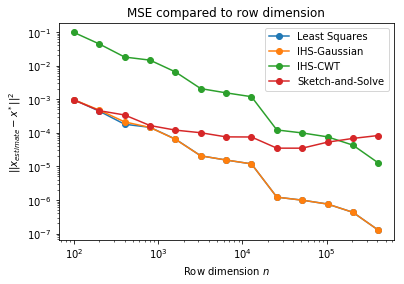

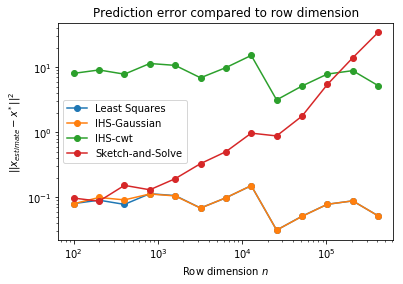

In [200]:
test_all_methods(100)

## Comparing convergence with sketch size and number of iterations

We now use the gaussian sketch to test convergence with a least squares problem of size $(n,d) = (6000,200)$ and unit variance.  The task is to see how fast the approximation converges to the least squares solution with varying sketch sizes, as well as the number of iterations required.
1. set $\gamma \in \{ 4,6,8 \}$ and measure log error to least squares estimator vs iterations. i.e. $\log \| x_t - x_{LS} \|$.
2. Same values of gamma and measure log-error to truth vs iterations i.e $\log \| x_t - x^* \|$

In [69]:
X, y, x_star = generate_data(nsamples=6000, nfeatures=200)
n,d = X.shape
gamma_vals = [4,6,8]
number_iterations = range(0,30, 5)

array([ 78.79602041,  17.49318729,  86.43638118,  71.76487369,
        64.43654778,  24.52958585,   9.48483268,  55.96853053,
        90.72091364,  96.34363814,  54.23028359,  95.07568757,
        68.67542283,  11.45651436,   6.14353669,  47.05663306,
        76.37864164,  51.38813722,  13.81661864,  77.83691105,
         2.34436251,  67.40119444,  12.96600775,   3.64450336,
        17.29458254,  54.37519192,   7.81889827,   7.30369582,
        93.03529281,   7.26291893,  65.93571914,  81.51233461,
        41.41247311,  55.8484279 ,  88.37449169,  68.94135691,
        44.27941673,  67.40620417,  16.41478642,  79.96555402,
        14.41352149,  30.34181641,  75.90942833,  18.97386159,
         9.17472151,  24.42058352,  32.06753797,  90.20254813,
        84.18382741,  67.21574002,  17.70241462,  39.23190079,
        83.62448163,  96.69810845,  86.51349912,  47.28334004,
        85.67207   ,  41.82793746,  89.57596099,  24.3394801 ,
        50.24596316,   1.95878596,  66.10285693,  65.66

In [106]:
# setup independent variables
iter_vs_lsq_errors = {gamma_vals[i]: np.zeros((len(number_iterations),1))\
                      for i in range(len(gamma_vals))}

iter_vs_truth_errors = {gamma_vals[i]: np.zeros((len(number_iterations),1))\
                      for i in range(len(gamma_vals))}
lsq_vs_truth_errors = np.ones(shape=(len(number_iterations),1))


array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]])

In [107]:
# Least squares estimator
optimal = sp.linalg.lstsq(X,y)
x_ls = optimal[0]
lsq_vs_truth_errors = np.log(1/np.sqrt(n)*norm(X@(x_ls-x_star))*lsq_vs_truth_errors)

for gamma in gamma_vals:
    
    sketch_size = int(gamma*d)
    
    
    
    for ii in range(len(number_iterations)):
        print("Testing gamma: {}, num_iterations: {}".format(gamma,ii))
        iter_num = number_iterations[ii]
    
    
        # x_t is IHS output after iter_num iterations
        x_t = iterative_hessian(data=X,targets=y,
                            sketch_size=sketch_size,num_iters=iter_num)
    
        iter_vs_lsq_errors[gamma][ii] = 1/np.sqrt(n)*norm(X@(x_t-x_ls))
        iter_vs_truth_errors[gamma][ii] = 1/np.sqrt(n)*norm(X@(x_t-x_star))
        


Testing gamma: 4, num_iterations: 0
Testing gamma: 4, num_iterations: 1
Testing gamma: 4, num_iterations: 2
Testing gamma: 4, num_iterations: 3
Testing gamma: 4, num_iterations: 4
Testing gamma: 4, num_iterations: 5
Testing gamma: 6, num_iterations: 0
Testing gamma: 6, num_iterations: 1
Testing gamma: 6, num_iterations: 2
Testing gamma: 6, num_iterations: 3
Testing gamma: 6, num_iterations: 4
Testing gamma: 6, num_iterations: 5
Testing gamma: 8, num_iterations: 0
Testing gamma: 8, num_iterations: 1
Testing gamma: 8, num_iterations: 2
Testing gamma: 8, num_iterations: 3
Testing gamma: 8, num_iterations: 4
Testing gamma: 8, num_iterations: 5


Text(0.5,1,'Error to least-squares solution vs iteration')

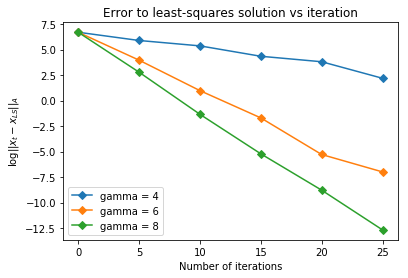

In [109]:
fig, ax = plt.subplots()

for gamma in gamma_vals:
    ax.plot(number_iterations, np.log(iter_vs_lsq_errors[gamma]),
            '-D', label="gamma = {}".format(gamma))
ax.legend()
ax.set_xlabel("Number of iterations")
ax.set_ylabel("$\log ||x_t - x_{LS} ||_A$")
ax.set_title('Error to least-squares solution vs iteration')

Text(0.5,1,'Error to ground truth vs iteration')

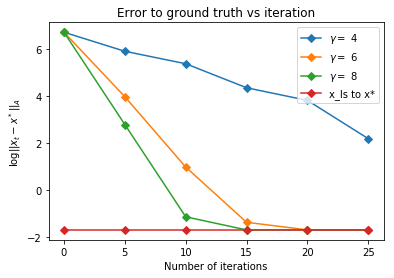

In [117]:
fig, ax = plt.subplots()

for gamma in gamma_vals:
    ax.plot(number_iterations, np.log(iter_vs_truth_errors[gamma]),
            '-D', label="$\gamma =$ {}".format(gamma))
    
ax.plot(number_iterations, lsq_vs_truth_errors, '-D', label="x_ls to x*")
ax.legend()
ax.set_xlabel("Number of iterations")
ax.set_ylabel("$\log ||x_t - x^* ||_A$")
ax.set_title('Error to ground truth vs iteration')

### Can we improve on the Gaussian sketch?
Although the Gaussian sketch works well and has many desirable properties it is dense and this results in being slow to apply to a matrix.  In the IHS paper a Hadamard transform is used to speed this up, however, we may be able to go even faster by using a _CountSketch_ or Clarkson-Woodruff transform which approximately preserves distances between vectors but is incredibly fast to apply.

In [119]:
from scipy.linalg import clarkson_woodruff_transform 

In [188]:
def iterative_hessian_cwt(data, targets, sketch_size, num_iters):
    '''
    Input:
    data - n x d matrix
    targets - n x 1 target variables
    num_iters - how many iterations to perform.  
    Need log(1/eps) -- > num_iters for eps accuracy where
    eps is relative error in the semi-norm ||u-v||_A = 
    1/sqrt(n)*||A(u-v)||_2.
    
    
    Add functionality for lower bound on sketch size
    '''
    A = data
    y = targets
    n,d = A.shape
    x0 = np.zeros(shape=(d,1))
    m = int(sketch_size) # sketching dimension
    
    ATy = A.T.dot(y)[:,None]
    covariance_mat = A.T.dot(A)
   
    for n_iter in range(int(num_iters)):
        #S = gaussian_sketch(m, n)
        #S_A = S.dot(A)
        
        # multiply by random gaussian?
        #gauss_rvs = np.random.randn(m,1)
        #pre_multiplier = (1/m**0.5)*np.diagflat(gauss_rvs)
        
        S_A = clarkson_woodruff_transform(A, sketch_size=m)
        B = S_A.T.dot(S_A)
        z = ATy - covariance_mat.dot(x0) + np.dot(S_A.T, (np.dot(S_A,x0)))
        sol = sp.linalg.lstsq(B,z)
        x_new = sol[0] 
        
        
        ### KEEP BELOW AS THIS WILL BE USED FOR LASSO OR
        ### PENALISED REGRESSION.
        
        #x0 = np.zeros((X.shape[0],1))
        #xt = np.zeros((2,1))
        #x_new = np.zeros((2,1))
        #for it in range(20):
        #    result = minimize(f2min, x0=x_new,args=(X,y,x_new),
        #                     method='L-BFGS-B', jac=False )
        #    print(result)
        #    x_new = result.x
        
        x_new = sp.linalg.solve(B,z)
        #print("ITERATION {}: ||x_t - x_t+1|| = {}".\
                  #format(n_iter, np.linalg.norm(x0-x_new)))
        x0 = x_new
    return np.ravel(x0)

In [189]:
x_cwt = iterative_hessian_cwt(data=X, targets=y, sketch_size=1000, num_iters=20)

In [190]:
x_cwt

array([ 87.83420708,  83.51608922,  88.10930529,  41.06132239,
         7.21834954,   7.52636803,  79.0844755 ,  51.65132119,
        45.13499078,  24.42898093])

In [191]:
coef

array([ 87.83298981,  83.51708527,  88.11073893,  41.06256909,
         7.2176591 ,   7.5295757 ,  79.08606507,  51.6497388 ,
        45.13224798,  24.42757582])

In [183]:
norm(x_cwt-coef)

0.0056015417417477672

In [184]:
X.shape

(102400, 10)